
# Linear Regression: estimation, prediction, checks, and extensions


## Utilities

In [1]:

import math
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(6)

def with_ax(title=None, xlabel=None, ylabel=None):
    fig, ax = plt.subplots(figsize=(6,4))
    if title: ax.set_title(title)
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    return fig, ax

def invgamma_rvs(alpha, beta, size=1, rng=None):
    # InvGamma(alpha, beta) with pdf proportional to beta^alpha x^{-(alpha+1)} exp(-beta/x)
    if rng is None: rng = np.random.default_rng()
    return 1.0 / rng.gamma(shape=alpha, scale=1.0/beta, size=size)

def bayes_linreg_conjugate(X, y, m0, V0, a0, b0):
    # Prior: beta | sigma2 ~ N(m0, sigma2 V0),  sigma2 ~ InvGamma(a0, b0)
    # Posterior: beta | sigma2 ~ N(mn, sigma2 Vn), sigma2 ~ InvGamma(an, bn)
    XT_X = X.T @ X
    V0_inv = np.linalg.inv(V0)
    Vn = np.linalg.inv(V0_inv + XT_X)
    mn = Vn @ (V0_inv @ m0 + X.T @ y)
    an = a0 + X.shape[0] / 2.0
    bn = b0 + 0.5*( y.T@y + m0.T@V0_inv@m0 - mn.T@np.linalg.inv(Vn)@mn )
    return mn, Vn, float(an), float(bn)

def sample_posterior_beta_sigma(mn, Vn, an, bn, draws=2000, rng=None):
    if rng is None: rng = np.random.default_rng()
    sigma2 = invgamma_rvs(an, bn, size=draws, rng=rng)
    betas = []
    for s2 in sigma2:
        L = np.linalg.cholesky(Vn * s2)
        z = rng.normal(size=len(mn))
        betas.append(mn + L @ z)
    return np.array(betas), sigma2

def posterior_predictive(Xnew, betas, sigma2):
    # Returns draws of ytilde (matrix draws x n_new)
    mu = betas @ Xnew.T  # draws x n_new
    eps = np.array([rng.normal(0, math.sqrt(s2), size=Xnew.shape[0]) for s2 in sigma2])
    return mu + eps  # same shape as mu

def credible_band(yrep, level=0.95):
    lo = (1-level)/2
    hi = 1-lo
    return np.quantile(yrep, [lo, hi], axis=0)

def bayes_R2(X, y, betas, sigma2):
    # Gelman et al. Bayesian R^2: var(mu) / (var(mu) + var(resid)), per draw then averaged
    mu_draws = betas @ X.T  # draws x n
    var_mu = mu_draws.var(axis=1, ddof=1)
    var_resid = sigma2  # homoskedastic
    R2 = var_mu / (var_mu + var_resid)
    return float(R2.mean()), R2

def epistemic_aleatoric(Xgrid, Vn, an, bn):
    # Posterior predictive variance decomposes (in expectation over sigma2):
    # E[sigma2] + E[sigma2] * diag(Xgrid Vn Xgrid^T)
    s2_bar = bn / (an - 1) if an > 1 else bn / an
    epsi = np.full(Xgrid.shape[0], s2_bar)
    epi = s2_bar * np.sum(Xgrid @ Vn * Xgrid, axis=1)
    return epi, epsi



## Simple linear regression on a synthetic body fat vs BMI dataset

We mimic the slides’ body fat example with a simple linear model
$$
y = \beta_0 + \beta_1 x + \varepsilon,\qquad \varepsilon \sim \mathcal{N}(0, \sigma^2).
$$


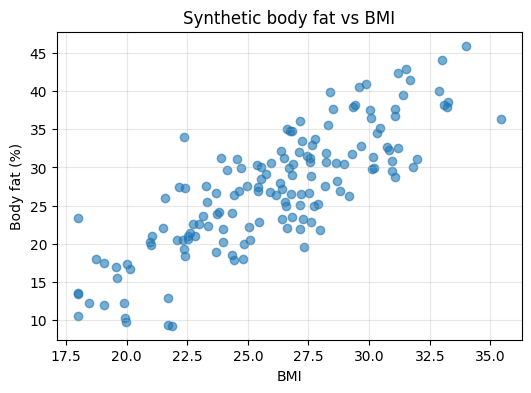

In [2]:

# Generate synthetic data roughly like BMI (x) vs body fat % (y)
n = 150
x = rng.normal(26, 4, size=n).clip(18, 38)
beta0_true, beta1_true, sigma_true = -20.0, 1.8, 4.5
y = beta0_true + beta1_true * x + rng.normal(0, sigma_true, size=n)

# Design matrix with intercept
X = np.column_stack([np.ones_like(x), x])

# Plot data
fig, ax = with_ax(title="Synthetic body fat vs BMI", xlabel="BMI", ylabel="Body fat (%)")
ax.scatter(x, y, alpha=0.6)
plt.show()



### Prior and posterior (conjugate Normal–Inverse-Gamma)

We use a weak prior:
- $\beta \mid \sigma^2 \sim \mathcal{N}(m_0, \sigma^2 V_0)$ with $m_0=(0,0)$ and $V_0=\operatorname{diag}(10^2, 10^2)$  
- $\sigma^2 \sim \mathrm{InvGamma}(a_0,b_0)$ with $a_0=2,\ b_0=10$

Then compute the posterior $(m_n, V_n, a_n, b_n)$ and draw parameter samples.


In [3]:

m0 = np.zeros(2)
V0 = np.diag([100.0, 100.0])
a0, b0 = 2.0, 10.0

mn, Vn, an, bn = bayes_linreg_conjugate(X, y, m0, V0, a0, b0)
betas, sigma2 = sample_posterior_beta_sigma(mn, Vn, an, bn, draws=6000, rng=rng)
mn, Vn, an, bn, betas.shape, sigma2.shape


(array([-16.14406898,   1.66123142]),
 array([[ 0.3070602 , -0.01152554],
        [-0.01152554,  0.00044221]]),
 77.0,
 1516.3238033973903,
 (6000, 2),
 (6000,))

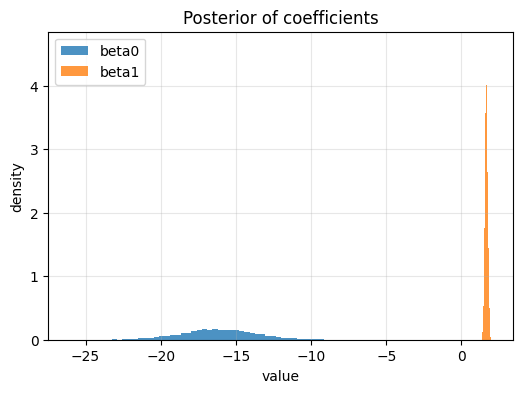

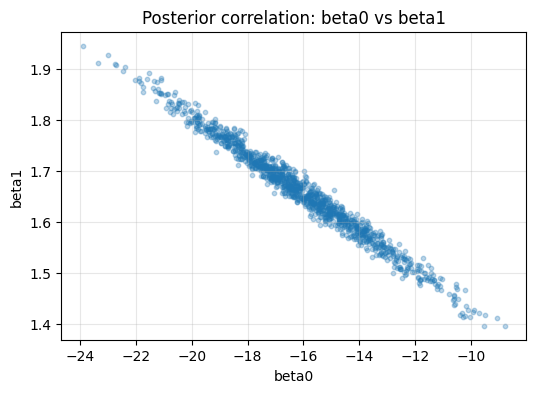

In [4]:

# Visualize posterior on coefficients
fig, ax = with_ax(title="Posterior of coefficients", xlabel="value", ylabel="density")
ax.hist(betas[:,0], bins=50, density=True, alpha=0.8, label="beta0")
ax.hist(betas[:,1], bins=50, density=True, alpha=0.8, label="beta1")
ax.legend(); plt.show()

# Scatter to show correlation between beta0 and beta1 (as in slides)
fig, ax = with_ax(title="Posterior correlation: beta0 vs beta1", xlabel="beta0", ylabel="beta1")
ax.scatter(betas[::5,0], betas[::5,1], alpha=0.3, s=10)
plt.show()



### Posterior predictive and uncertainty bands

For a grid of BMI values, we compute the predictive distribution and decompose uncertainty into
- **Epistemic** (parameter) uncertainty  
- **Aleatoric** (noise) uncertainty


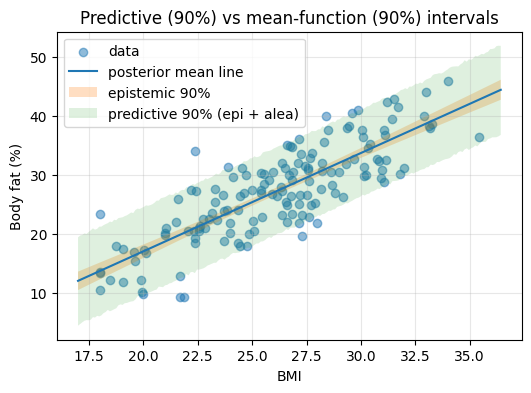

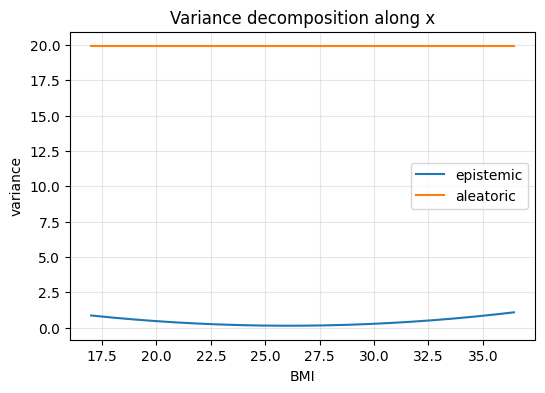

In [5]:

# Grid for plotting lines and intervals
xg = np.linspace(x.min()-1, x.max()+1, 200)
Xg = np.column_stack([np.ones_like(xg), xg])

# Predictive draws and interval
yrep_g = posterior_predictive(Xg, betas, sigma2)
q05, q95 = credible_band(yrep_g, 0.90)

# Mean-function (epistemic) interval using posterior betas only (no noise)
mu_g = betas @ Xg.T
mu_q05, mu_q95 = np.quantile(mu_g, [0.05, 0.95], axis=0)
mu_mean = mu_g.mean(axis=0)

# Plot
fig, ax = with_ax(title="Predictive (90%) vs mean-function (90%) intervals", xlabel="BMI", ylabel="Body fat (%)")
ax.scatter(x, y, alpha=0.5, label="data")
ax.plot(xg, mu_mean, label="posterior mean line")
ax.fill_between(xg, mu_q05, mu_q95, alpha=0.25, label="epistemic 90%")
ax.fill_between(xg, q05, q95, alpha=0.15, label="predictive 90% (epi + alea)")
ax.legend(); plt.show()

# Decomposition numerically at grid using closed-form expectation
epi, alea = epistemic_aleatoric(Xg, Vn, an, bn)
fig, ax = with_ax(title="Variance decomposition along x", xlabel="BMI", ylabel="variance")
ax.plot(xg, epi, label="epistemic")
ax.plot(xg, alea, label="aleatoric")
ax.legend(); plt.show()



### Posterior predictive checks and Bayesian $R^2$

We simulate replicated datasets from the posterior predictive and compare them visually to the observed data.  
We also compute Bayesian $R^2$ (Gelman et al.) to summarize explained vs residual variance.


In [6]:

# Posterior predictive for training X
yrep = posterior_predictive(X, betas, sigma2)
r2_mean, r2_draws = bayes_R2(X, y, betas, sigma2)
r2_mean, (np.quantile(r2_draws, [0.05, 0.5, 0.95]))


(0.6763311230295119, array([0.61517901, 0.67886487, 0.73053598]))

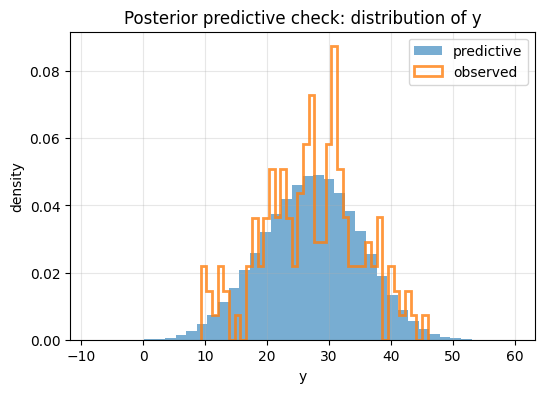

In [7]:

# PPC: overlay histograms of observed vs replicated
fig, ax = with_ax(title="Posterior predictive check: distribution of y", xlabel="y", ylabel="density")
ax.hist(yrep.ravel(), bins=40, density=True, alpha=0.6, label="predictive")
ax.hist(y, bins=40, density=True, alpha=0.8, histtype="step", linewidth=2, label="observed")
ax.legend(); plt.show()



## Multiple linear regression: credit card balance demo

We simulate features similar to the slides: **Limit**, **Income**, and a binary **Student** indicator, and fit
a Bayesian linear regression. We compare explained variance as features are added.


In [8]:

# Simulate features and balance
N = 300
Limit = rng.normal(4000, 1500, size=N).clip(500, 10000)
Income = rng.normal(60, 25, size=N).clip(10, 200)  # in $k
Student = rng.integers(0, 2, size=N)
eps = rng.normal(0, 350, size=N)

# True model (unknown to learner)
y_bal = 200 + 0.14*Limit + 6.0*Income + 420*Student + eps

def fit_bayes_lr(y, cols):
    X = np.column_stack([np.ones(N)] + cols)
    p = X.shape[1]
    m0 = np.zeros(p)
    V0 = np.eye(p)*1e4  # weak prior
    a0,b0 = 2.0, 1e5
    mn,Vn,an,bn = bayes_linreg_conjugate(X, y, m0, V0, a0, b0)
    betas, s2 = sample_posterior_beta_sigma(mn, Vn, an, bn, draws=4000, rng=rng)
    r2_mean,_ = bayes_R2(X, y, betas, s2)
    return (mn,Vn,an,bn,betas,s2,r2_mean)

res_limit   = fit_bayes_lr(y_bal, [Limit])
res_lim_inc = fit_bayes_lr(y_bal, [Limit, Income])
res_full    = fit_bayes_lr(y_bal, [Limit, Income, Student])

res_limit[-1], res_lim_inc[-1], res_full[-1]


(0.1990274392058363, 0.2586518504674801, 0.4915966870688803)

In [9]:

# Posterior intervals for coefficients in the full model
mn,Vn,an,bn,betas,s2,_ = res_full
q = np.quantile(betas, [0.03, 0.5, 0.97], axis=0)  # ~94% HDI proxy
q


array([[8.79686270e+00, 1.08870634e-01, 4.76154228e+00, 4.00408682e+02],
       [1.54546743e+02, 1.33773462e-01, 6.32061343e+00, 4.76495318e+02],
       [3.03960336e+02, 1.58615624e-01, 7.92938916e+00, 5.54249861e+02]])


The intervals that avoid zero suggest statistically relevant predictors (in this synthetic example).



## Interactions: advertising demo

We simulate **TV** and **radio** budgets and **Sales** with a positive interaction term, then compare models with and without the interaction.


In [10]:

M = 200
TV = rng.uniform(0, 300, size=M)
radio = rng.uniform(0, 50, size=M)
noise = rng.normal(0, 1.8, size=M)
sales = 2.0 + 0.04*TV + 0.15*radio + 0.003*TV*radio + noise  # synergy

def r2_from_model(y, cols):
    X = np.column_stack([np.ones(len(y))] + cols)
    m0 = np.zeros(X.shape[1]); V0 = np.eye(X.shape[1])*1e4; a0,b0 = 2.0, 10.0
    mn,Vn,an,bn = bayes_linreg_conjugate(X, y, m0, V0, a0, b0)
    betas,s2 = sample_posterior_beta_sigma(mn, Vn, an, bn, draws=3000, rng=rng)
    r2,_ = bayes_R2(X, y, betas, s2)
    return r2

r2_no_int = r2_from_model(sales, [TV, radio, rng.uniform(0,100, size=M)*0])  # keep shape example; third col ignored
r2_int    = r2_from_model(sales, [TV, radio, TV*radio])
r2_no_int, r2_int


(0.8974913856173827, 0.9818296967318804)


## Outliers and robustness

Normal likelihoods can be sensitive to outliers. We simulate a clean dataset and add a few extreme points,
then compare the fitted lines (Bayesian normal-likelihood model) with and without the outliers.


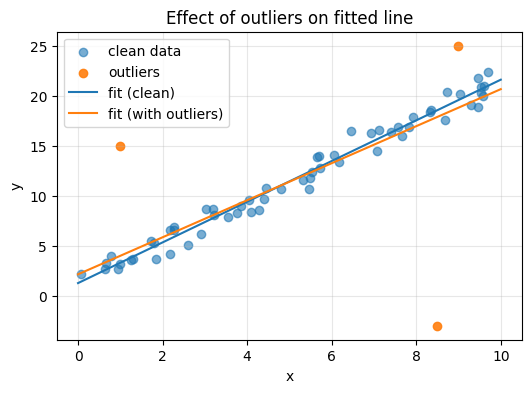

In [11]:

# Clean data
n0 = 60
x0 = rng.uniform(0, 10, size=n0)
y0 = 1.5 + 2.0*x0 + rng.normal(0, 1.0, size=n0)

# Add outliers
x_out = np.array([1.0, 8.5, 9.0])
y_out = np.array([15.0, -3.0, 25.0])
x1 = np.concatenate([x0, x_out])
y1 = np.concatenate([y0, y_out])

def fit_line(x, y):
    X = np.column_stack([np.ones_like(x), x])
    m0 = np.zeros(2); V0 = np.eye(2)*1e3; a0,b0 = 2.0, 1.0
    mn,Vn,an,bn = bayes_linreg_conjugate(X, y, m0, V0, a0, b0)
    betas,s2 = sample_posterior_beta_sigma(mn, Vn, an, bn, draws=4000, rng=rng)
    return mn,Vn,an,bn,betas,s2

fit_clean = fit_line(x0, y0)
fit_dirty = fit_line(x1, y1)

# Plot post mean lines
xg = np.linspace(0, 10, 200)
Xg = np.column_stack([np.ones_like(xg), xg])

mu_clean = fit_clean[4].mean(axis=0) @ Xg.T
mu_dirty = fit_dirty[4].mean(axis=0) @ Xg.T

fig, ax = with_ax(title="Effect of outliers on fitted line", xlabel="x", ylabel="y")
ax.scatter(x0, y0, alpha=0.6, label="clean data")
ax.scatter(x_out, y_out, alpha=0.9, label="outliers")
ax.plot(xg, mu_clean, label="fit (clean)")
ax.plot(xg, mu_dirty, label="fit (with outliers)")
ax.legend(); plt.show()



For a robust alternative, replace the Normal likelihood with a Student-$t$; implementing MCMC for that is beyond this self-contained notebook, but the slides show the idea.



## Polynomial regression and shrinkage

Adding polynomial terms can overfit with few data. In a Bayesian setup, place **stronger priors** around zero on higher-degree coefficients to regularize (shrink) them.


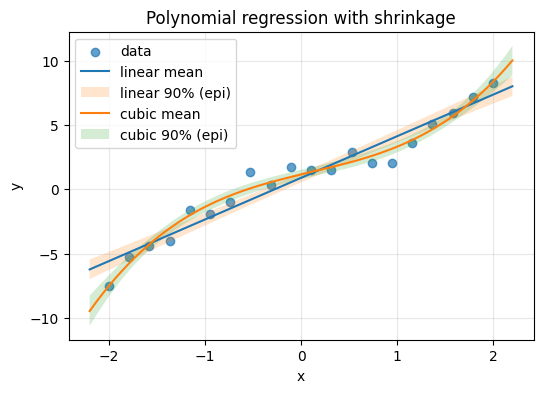

array([[ 7.96826847e-01,  1.28681417e+00, -3.65739029e-01,
         3.69179079e-01],
       [ 1.15957107e+00,  1.80248299e+00, -1.81492719e-01,
         5.43847515e-01],
       [ 1.52690537e+00,  2.30467703e+00,  1.66487907e-03,
         7.21038952e-01]])

In [12]:

# Few points from a cubic ground truth
n_small = 20
xs = np.linspace(-2, 2, n_small)
ys = 1.0 + 1.5*xs - 0.2*xs**2 + 0.6*xs**3 + rng.normal(0, 0.7, size=n_small)

# Design matrices
X_lin = np.column_stack([np.ones(n_small), xs])
X_cub = np.column_stack([np.ones(n_small), xs, xs**2, xs**3])

# Priors: weak for linear, shrinking for higher degrees
m0_lin = np.zeros(2); V0_lin = np.diag([10.0, 10.0])
m0_cub = np.zeros(4); V0_cub = np.diag([10.0, 10.0, 1.0, 0.5])  # stronger shrinkage on x^2 and x^3
a0,b0 = 2.0, 1.0

mnL,VL,aL,bL = bayes_linreg_conjugate(X_lin, ys, m0_lin, V0_lin, a0, b0)
mnC,VC,aC,bC = bayes_linreg_conjugate(X_cub, ys, m0_cub, V0_cub, a0, b0)
bL,s2L = sample_posterior_beta_sigma(mnL, VL, aL, bL, draws=4000, rng=rng)
bC,s2C = sample_posterior_beta_sigma(mnC, VC, aC, bC, draws=4000, rng=rng)

xg = np.linspace(-2.2, 2.2, 200)
Xg_lin = np.column_stack([np.ones_like(xg), xg])
Xg_cub = np.column_stack([np.ones_like(xg), xg, xg**2, xg**3])

mu_lin = bL @ Xg_lin.T
mu_cub = bC @ Xg_cub.T

mu_lin_m = mu_lin.mean(axis=0)
mu_cub_m = mu_cub.mean(axis=0)
q_lin = np.quantile(mu_lin, [0.05,0.95], axis=0)
q_cub = np.quantile(mu_cub, [0.05,0.95], axis=0)

fig, ax = with_ax(title="Polynomial regression with shrinkage", xlabel="x", ylabel="y")
ax.scatter(xs, ys, alpha=0.7, label="data")
ax.plot(xg, mu_lin_m, label="linear mean")
ax.fill_between(xg, q_lin[0], q_lin[1], alpha=0.2, label="linear 90% (epi)")
ax.plot(xg, mu_cub_m, label="cubic mean")
ax.fill_between(xg, q_cub[0], q_cub[1], alpha=0.2, label="cubic 90% (epi)")
ax.legend(); plt.show()

# Inspect posterior for higher-degree coefs
qcoef = np.quantile(bC, [0.05, 0.5, 0.95], axis=0)
qcoef



Note how stronger priors pull higher-degree coefficients toward zero (shrinkage), which helps combat overfitting with small $n$.



## Key takeaways
- Conjugate **Normal–Inverse-Gamma** priors give closed-form posteriors for linear regression and **Student-$t$** predictives.  
- **Posterior predictive checks** and **Bayesian $R^2$** help evaluate fit; **epistemic vs aleatoric** variance clarifies uncertainty sources.  
- Multiple regression and **interactions** are straightforward; watch how explained variance changes as features are added.  
- With few data, prefer **shrinkage priors** to stabilize polynomial models; robust likelihoods (e.g., Student-$t$) can mitigate outliers.
